# Bike Rentals Prediction Project

### Introduction

One of the most efficient ways to travel in major metropolitan cities in the United States is via bicycle. Having lived in Chicago my entire life, I can verify this is indeed the case. In fact, city governments have realized this rather obvious fact, and have resultantly created programs to try and monetize the transportation process even further. The Divvy bike system in Chicago is a perfect example.

The goal of this project will be fairly straight forward. We imagine that we are employed by a company like Divvy, and that the company wishes to predict how many bikes will be rented in the next hour. To accomplish this task, we will create a few machine leanring models to help generate these predictions.

### Preprocessing and Preliminary Analysis

In [1]:
# We first import all of our necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [2]:
# We then construct a dataframe for our data and plot a histogram of the values
bike_rentals = pd.read_csv("bike_rental_hour.csv")
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


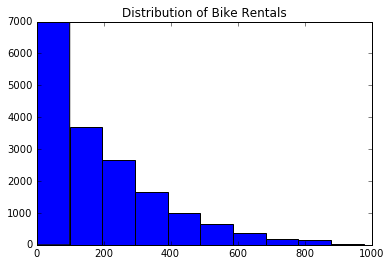

In [3]:
# Let's take a look at the "cnt" columns, which stands for "casual+registered"
%matplotlib inline
total_rented = bike_rentals["cnt"]
plt.hist(total_rented)
plt.title("Distribution of Bike Rentals")

In [4]:
# Let's examine how each column is correlated with the "cnt" column
correlations = abs(bike_rentals.corr()["cnt"]).sort_values(ascending=False)
correlations

cnt           1.000000
registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
hum           0.322911
instant       0.278379
yr            0.250495
season        0.178056
weathersit    0.142426
mnth          0.120638
windspeed     0.093234
holiday       0.030927
workingday    0.030284
weekday       0.026900
Name: cnt, dtype: float64

### Feature Engineering

It is often the case that we need to either (1) engineer new features from existing ones or (2) alter the existing features to better align with the assumptions of our models. For example, the hours column has values between 0 and 24. While we understand that these numbers represent hours of the day, a model like Linear Regression will assume that the magnitude of each number makes a substantial difference. As such, we will begin the feature engineering process by applying a new mapping to this column.

In [5]:
# We create a function that groups our hours together
def assign_label(df, column):  # Takes in a dataframe and column input
    new_column = []  # Create an empty list to be used as a new column
    for value in df[column]:  # Iterate through our column vector
        if 6 <= value <= 12:
            new_column.append(1)
        elif 12 < value <= 18:
            new_column.append(2)
        elif 18 < value <= 24:
            new_column.append(3)
        elif 0 <= value < 6:
            new_column.append(4)
    df["time_label"] = new_column
    return df

In [6]:
# We now apply our function to our dataframe
altered_bikes = assign_label(bike_rentals, "hr")

In [7]:
# Let's check to make sure our transformation worked
altered_bikes["time_label"].value_counts()

1    5088
2    4375
4    4276
3    3640
Name: time_label, dtype: int64

In [8]:
altered_bikes.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,4
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,4
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,4
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,4
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,4


### Data Splitting and Cleaning

No matter which machine model we choose to implement, and no matter its complexity, the two things we will always have to do in during the model construction process is:
- 1: Clean our data to allow our model to accept it
- 2: Split our data into a training and test set (possibly cross-validation)

In the following section, we perform each of these tasks

In [9]:
# We first check to see if our data needs to be cleaned (it doesn't)
altered_bikes.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
time_label    0
dtype: int64

In [10]:
# We then split the data into a training set and a test set
train = altered_bikes.sample(frac=.80, axis=0)
test = altered_bikes.loc[~bike_rentals.index.isin(train.index)]

### Model 1: Linear Regression

The first model we will implement will be a standard Linear Regression model. We shall use rmse as our error metric to determine our model's accuracy.

In [11]:
# We first select the columns we wish to use as features based on our correlations
features = ["temp", "atemp", "time_label", "hum", "instant", "yr", "season"]  # Correlations > .33
lin_reg = LinearRegression()
lin_reg.fit(train[features], train["cnt"])
predictions = lin_reg.predict(test[features])
lr_rmse = np.sqrt(mean_squared_error(test["cnt"], predictions))

In [12]:
print("Our rmse score for linear regression is:", lr_rmse)

Our rmse score for linear regression is: 135.63563269094513


### Linear Regression Conclusion

Our RMSE score indicates that for any given day, we are on average about 135 bike rentals off of the actual day's total. Based upon our histogram, the most common number of rentals are between 0-200 per day. As such, this is an extremely high error rate, and we should not be satisfied with this answer.

Before we go and try to clean and modify our data for the Linear Regression model, let's try to create a second model that has the potential to be better.

### Model 2: Decision Tree

The second model we will implement will be a decision tree model.

In [13]:
# We create our decision tree below
dt_reg = DecisionTreeRegressor()
dt_reg.fit(train[features], train["cnt"])
dt_predictions = dt_reg.predict(test[features])
dt_rmse = np.sqrt(mean_squared_error(test["cnt"], dt_predictions))

In [14]:
print("Our rmse score for our Decision Tree is:", dt_rmse)

Our rmse score for our Decision Tree is: 136.6913547639487


It appears that our decision tree model is about as accurate as our linear regression model. However, let's experiment with some of the hyperparameters of the DecisionTreeRegressor class to try and generate a better accuracy.

In [15]:
min_leaf_values = [7, 9, 11, 13]

for leaf in min_leaf_values:
    dt_reg = DecisionTreeRegressor(min_samples_leaf=leaf)
    dt_reg.fit(train[features], train["cnt"])
    predictions = dt_reg.predict(test[features])
    rmse = np.sqrt(mean_squared_error(test["cnt"], predictions))
    print("The score for a min_sample_leaf of {} is {}".format(leaf, rmse))

The score for a min_sample_leaf of 7 is 123.54935920854683
The score for a min_sample_leaf of 9 is 123.02389705563805
The score for a min_sample_leaf of 11 is 121.99715012969115
The score for a min_sample_leaf of 13 is 120.5158518919812


Changing the value of this hyperparameter altered our score very little from the default value...it appears a value of 13 would be the best. In any event, a score of 120 is still pretty lackluster. Let's try one more model to generate a better score.

### Model 3: Random Forest

In our last model, we will create an ensemble model using the RandomForestRegressor class form scikitlearn. I Personally expect this model to perform the best of all three that we have created thus far.

In [16]:
# We create our model in the code block below
rf_reg = RandomForestRegressor()
rf_reg.fit(train[features], train["cnt"])
rf_predictions = rf_reg.predict(test[features])
rf_rmse = np.sqrt(mean_squared_error(test["cnt"], rf_predictions))
print("Our rmse score for our Random Forest is:", rf_rmse)

Our rmse score for our Random Forest is: 113.27713057487522


Our hypothesis was correct. Similar to the regular decision tree model, let's see if we can tinker with the hyperparameter value of min_samples_leaf with the random forest regressor.

In [17]:
rf_sample_values = [7, 9, 11, 13, 100]
for leaf in rf_sample_values:
    rf_reg = RandomForestRegressor(min_samples_leaf=leaf)
    rf_reg.fit(train[features], train["cnt"])
    predictions = rf_reg.predict(test[features])
    rmse = np.sqrt(mean_squared_error(test["cnt"], predictions))
    print("The score for a min_sample_leaf of {} is {}".format(leaf, rmse))

The score for a min_sample_leaf of 7 is 114.42711162389283
The score for a min_sample_leaf of 9 is 113.963397149579
The score for a min_sample_leaf of 11 is 113.51393053771496
The score for a min_sample_leaf of 13 is 113.69903628924176
The score for a min_sample_leaf of 100 is 116.2343304671954


It appears that this hyperparamter is not going to help us improve our model. Instead, let's tinker with the n_estimator hyperparameter value.

In [20]:
n_estimators = [50, 100, 150, 175, 200]
for n in n_estimators:
    rf_reg = RandomForestRegressor(n_estimators=n)
    rf_reg.fit(train[features], train["cnt"])
    predictions = rf_reg.predict(test[features])
    rmse = np.sqrt(mean_squared_error(test["cnt"], predictions))
    print("The score for an n_estimator of {} is {}".format(n, rmse))

The score for an n_estimator of 50 is 107.59884922072753
The score for an n_estimator of 100 is 108.5916115689227
The score for an n_estimator of 150 is 108.85523930184745
The score for an n_estimator of 175 is 108.58788560734577
The score for an n_estimator of 200 is 108.93238689853827


It appears that this hyperparameter had much more of an affect on our model than the min_sample_leaf! As we increased the number of trees, we performed slightly worse than the previous one. As a result, we should use an n_estimator of 50 or less for better accuracy.

## Conclusion

For this project, we were able to create 3 machine learning models to help predict the number of bicycles that would be rented on any given day. The three models that we constructed were a Linear Regression model, a Decision Tree model, and a Random Forest Regression model. 

Unsurprisingly, the Random Forest model performed the best. However, there are a number of different routes we could take to improve this models performance. For starters, we didn't scale our data, nor did we remove outliers. Secondly, we could try to expand our feature engineering process by combining or adding additional features to improve model accuracy. We also could use a method like GridSearchCV to help us choose the best hyperparameters possible for this model. 

Regardless, this project showcases my ability to create different Machine Learning models and to be able to choose the one that helps us achieve our goal appropriately. 